In [1]:
import pandas as pd
from copy import deepcopy as dc
import itertools
from itertools import combinations
from itertools import permutations
import numpy as np
from scipy.optimize import linprog
import math
import pickle
from graphviz import Digraph
import time
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# INI

In [2]:
def get_signature(x):
    return_string = ''
    for ele in list_entite:
        return_string = return_string + str(int(x[ele]))
    return return_string


def simulation(ini_d_s, ini_c_s, nb_ite):
    """
    initial_discrete_state = '100'
    initial_domain = [0.1,0.2,0.3]
    """
    nb_dim = len(ini_c_s)
    return_series = np.zeros((1, nb_dim))
    times = np.zeros((1, 1))
    count = 0
    for dim_i in range(nb_dim):
        return_series[0][dim_i] = int(ini_d_s[dim_i]) + ini_c_s[dim_i]
    times[0][0] = 0
    d_s = ini_d_s
    c_s = ini_c_s.copy()
    for num_ite in range(nb_ite):
        # instant transition
        instant_transition = True
        current_d_s = dc(d_s)
        c_count = 0
        while instant_transition:
            instant_transition = False
            for dim_i in range(nb_dim):
                if c_s[dim_i] == 1 and classify_boundary(d_s, dim_i, 1) == 'output':
                    instant_transition = True
                    c_s[dim_i] = 0
                    d_s = d_s[0:dim_i] + str(int(d_s[dim_i]) + 1) + d_s[dim_i + 1:]
                    break
                elif c_s[dim_i] == 0 and classify_boundary(d_s, dim_i, -1) == 'output':
                    instant_transition = True
                    c_s[dim_i] = 1
                    d_s = d_s[0:dim_i] + str(int(d_s[dim_i]) - 1) + d_s[dim_i + 1:]
                    break
            c_count = c_count + 1
            #             print(d_s)
            if c_count > 1 and current_d_s == d_s:
                return (return_series, times)
        delta_t = math.inf
        first_touch_dim = nb_dim
        first_touch_sign = 0
        one_return_series = np.zeros((1, nb_dim))
        one_times = np.zeros((1, 1))
        set_att = []
        for dim_i in range(nb_dim):
            if c_s[dim_i] == 1 and classify_boundary(d_s, dim_i, 1) == 'attractif':
                set_att = set_att + [dim_i]
            elif c_s[dim_i] == 0 and classify_boundary(d_s, dim_i, -1) == 'attractif':
                set_att = set_att + [dim_i]
        if len(set_att) == nb_dim:
            return (return_series, times)
        for dim_i in range(nb_dim):
            if dim_i not in set_att:
                speed = get_celerity(d_s, dim_i)
                if speed > 0:
                    delta = (1 - c_s[dim_i]) / speed
                    sign = 1
                elif speed < 0:
                    delta = (0 - c_s[dim_i]) / speed
                    sign = 0
                elif speed == 0:
                    delta = math.inf
                if delta < delta_t:
                    delta_t = delta
                    first_touch_dim = dim_i
                    first_touch_sign = sign
        # check if two boundary are reached at the same time
        for dim_i in range(nb_dim):
            if dim_i not in set_att:
                speed = get_celerity(d_s, dim_i)
                if speed > 0:
                    delta = (1 - c_s[dim_i]) / speed
                    sign = 1
                elif speed < 0:
                    delta = (0 - c_s[dim_i]) / speed
                    sign = 0
                elif speed == 0:
                    delta = math.inf
                if delta == delta_t and dim_i != first_touch_dim:
                    print('reach two new boundaries at the same time!')

        c_s[first_touch_dim] = first_touch_sign
        count = count + delta_t
        for dim_i in range(nb_dim):
            if dim_i not in set_att and dim_i != first_touch_dim:
                speed = get_celerity(d_s, dim_i)
                c_s[dim_i] = c_s[dim_i] + delta_t * speed
            one_return_series[0][dim_i] = int(d_s[dim_i]) + c_s[dim_i]
        #         print('discrete state:',d_s)
        #         print('continuous state:',c_s)
        #         print('***********************')
        one_times[0][0] = count
        return_series = np.vstack([return_series, one_return_series])
        times = np.vstack([times, one_times])
    return (return_series, times)
def classify_boundary(state, dim, domain):
    """
    state: '010'
    dim: 2
    domain: 1/0/-1
    """
    current_row = celerities.query('signature == @state')
    speed = current_row['c_' + list_entite[dim]].values[0]
    if domain == 0:
        return 'interior'
    elif domain == 1:
        if speed > 0:
            if int(state[dim]) == max_level[list_entite[dim]]:
                return 'attractif'
            else:
                upper_discrete_state = state
                upper_discrete_state = list(upper_discrete_state)
                upper_discrete_state[dim] = str(int(upper_discrete_state[dim]) + 1)
                upper_discrete_state = "".join(upper_discrete_state)
                upper_speed = celerities.query('signature == @upper_discrete_state')['c_' + list_entite[dim]].values[0]
                if upper_speed <= 0:
                    return 'attractif'
                elif upper_speed > 0:
                    return 'output'
        elif speed == 0:
            return 'neutral'
        elif speed < 0:
            return 'input'
    elif domain == -1:
        if speed < 0:
            if int(state[dim]) == 0:
                return 'attractif'
            else:
                lower_discrete_state = state
                lower_discrete_state = list(lower_discrete_state)
                lower_discrete_state[dim] = str(int(lower_discrete_state[dim]) - 1)
                lower_discrete_state = "".join(lower_discrete_state)
                lower_speed = celerities.query('signature == @lower_discrete_state')['c_' + list_entite[dim]].values[0]
                if lower_speed >= 0:
                    return 'attractif'
                elif lower_speed < 0:
                    return 'output'
        elif speed == 0:
            return 'neutral'
        elif speed > 0:
            return 'input'

def get_constraint1(discrete_domain):
    dim_free = []
    for one_dim in range(len(discrete_domain)):
        if discrete_domain[one_dim] not in [-1, 1]:
            dim_free = dim_free + [one_dim]
    last_constraint_a = np.zeros((2 * len(dim_free), len(discrete_domain)))
    last_constraint_b = np.zeros((2 * len(dim_free), 1))
    for one_dim in range(len(dim_free)):
        last_constraint_a[one_dim * 2][dim_free[one_dim]] = 1
        last_constraint_a[one_dim * 2 + 1][dim_free[one_dim]] = -1
        last_constraint_b[one_dim * 2][0] = 1
        last_constraint_b[one_dim * 2 + 1][0] = 0
    return last_constraint_a, last_constraint_b
        
def get_celerity(state, dim):
    current_row = celerities.query('signature == @state')
    speed = current_row['c_' + list_entite[dim]].values[0]
    return speed

def verify_fixed_point(ds,cs):
    nb_dim = len(cs)
    res = True
    for i in range(nb_dim):
        if cs[i] != 1 and cs[i] != 0:
            return False
    for i in range(nb_dim):
        if cs[i] == 1 and classify_boundary(ds, i, 1) == 'attractif':
            res = res and True
        elif cs[i] == 0 and classify_boundary(ds, i, -1) == 'attractif':
            res = res and True
        else:
            return False
    return res

def one_step_simulation(ds,cs):
    temp_ds = dc(ds)
    temp_cs = dc(cs)
    nb_dim = len(cs)
    for dim_i in range(nb_dim):
        if temp_cs[dim_i] == 1 and classify_boundary(temp_ds, dim_i, 1) == 'output':
            temp_cs[dim_i] = 0
            temp_ds = temp_ds[0:dim_i] + str(int(temp_ds[dim_i]) + 1) + temp_ds[dim_i + 1:]
            return temp_ds,temp_cs
        elif temp_cs[dim_i] == 0 and classify_boundary(temp_ds, dim_i, -1) == 'output':
            temp_cs[dim_i] = 1
            temp_ds = temp_ds[0:dim_i] + str(int(temp_ds[dim_i]) - 1) + temp_ds[dim_i + 1:]
            return temp_ds,temp_cs
    delta_t = math.inf
    first_touch_dim = nb_dim
    first_touch_sign = 0
    set_att = []
    for dim_i in range(nb_dim):
        if temp_cs[dim_i] == 1 and classify_boundary(temp_ds, dim_i, 1) == 'attractif':
            set_att = set_att + [dim_i]
        elif temp_cs[dim_i] == 0 and classify_boundary(temp_ds, dim_i, -1) == 'attractif':
            set_att = set_att + [dim_i]
    
    for dim_i in range(nb_dim):
        if dim_i not in set_att:
            speed = get_celerity(temp_ds, dim_i)
            if speed > 0:
                delta = (1 - temp_cs[dim_i]) / speed
                sign = 1
            elif speed < 0:
                delta = (0 - temp_cs[dim_i]) / speed
                sign = 0
            elif speed == 0:
                delta = math.inf
            if delta < delta_t:
                delta_t = delta
                first_touch_dim = dim_i
                first_touch_sign = sign

    temp_cs[first_touch_dim] = first_touch_sign
    for dim_i in range(nb_dim):
        if dim_i not in set_att and dim_i != first_touch_dim:
            speed = get_celerity(temp_ds, dim_i)
            temp_cs[dim_i] = temp_cs[dim_i] + delta_t * speed
    return temp_ds,temp_cs
def get_dd(cs):
    """ get the discrete domain of a hybrid state
    """
    temp_dd = []
    for i in range(len(cs)):
        if cs[i] == 0:
            temp_dd = temp_dd + [-1]
        elif cs[i] == 1:
            temp_dd = temp_dd + [1]
        else:
            temp_dd = temp_dd + [0]
    return temp_dd

def check_reach_singular(ds,cs,temp_r_ds,temp_r_interval):
    nb_dim = len(cs)
    if ds != temp_r_ds:
        return False
    elif ds == temp_r_ds:
        temp = True
        for i in range(nb_dim):
            if cs[i] >= temp_r_interval[i][0] and cs[i] <= temp_r_interval[i][1]:
                temp = temp and True
            else:
                temp = False
                break
        return temp

def check_reach(ds1,cs1,ds2,cs2,temp_r_ds,temp_r_interval):
    nb_dim = len(cs1)
    if ds2 != ds1:
        if ds2 != temp_r_ds:
            return False
        else:
            temp = True
            for i in range(nb_dim):
                if cs2[i] >= temp_r_interval[i][0] and cs2[i] <= temp_r_interval[i][1]:
                    temp = temp and True
                else:
                    temp = False
                    break
            return temp
    elif ds2 == ds1 == temp_r_ds:
        dim_att = []
        for i in range(nb_dim):
            if cs1[i] == cs2[i]:
                dim_att = dim_att + [i]
        for i in dim_att:
            if (temp_r_interval[i][0]>cs1[i]) or (cs1[i] > temp_r_interval[i][1]):
                return False
        for i in range(nb_dim):
            if i not in dim_att:
                for j in [0,1]:
                    if min(cs1[i],cs2[i]) <= temp_r_interval[i][j] <= max(cs1[i],cs2[i]):
                        temp=True
                        temp_cs = dc(cs1)
                        ratio = (temp_r_interval[i][j] - cs1[i])/(cs2[i] - cs1[i])
                        for k in range(nb_dim):
                            if k not in dim_att:
                                temp_cs[k] = cs1[k] + (cs2[k] -cs1[k])*ratio
                                if k != i:
                                    if temp_r_interval[k][0] <= temp_cs[k] <= temp_r_interval[k][1]:
                                        temp = temp and True
                                    else:
                                        temp = temp and False
                        if temp == True:
                            return True
        return False
    else:
        return False

def get_transition_matrix(state, first_domain, second_domain):
    """
    state: '0101'
    first_domain(second_domain): [0,-1,1,0]
    """
    # get first reach dimension
    first_reach_dim = len(second_domain) + 1
    for num_dim in range(len(second_domain)):
        if second_domain[num_dim] in [-1, 1] and first_domain[num_dim] != second_domain[num_dim]:
            first_reach_dim = num_dim
            break
    # Calculate delta t
    speed = get_celerity(state, first_reach_dim)
    if first_domain[first_reach_dim] in [1, -1]:
        if second_domain[first_reach_dim] == 1:
            delta_cons = 1 / speed
            delta_var = 0
        elif second_domain[first_reach_dim] == -1:
            delta_cons = (-1) / speed
            delta_var = 0
    else:
        if second_domain[first_reach_dim] == 1:
            delta_cons = 1 / speed
            delta_var = (-1) / speed
        elif second_domain[first_reach_dim] == -1:
            delta_cons = 0
            delta_var = (-1) / speed
    # calculate transition matrix
    nb_dim = len(second_domain)
    # the supplementary dimension is 1
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    t_m[nb_dim][nb_dim] = 1
    delta1 = time.time()
    for num_dim in range(nb_dim):
        if num_dim == first_reach_dim:
            # for first reached dimension
            if second_domain[first_reach_dim] == 1:
                t_m[first_reach_dim][nb_dim] = 1
            elif second_domain[first_reach_dim] == -1:
                t_m[first_reach_dim][nb_dim] = 0
        else:
            # slide
            if second_domain[num_dim] in [-1, 1] and second_domain[num_dim] == first_domain[num_dim]:
                t_m[num_dim][num_dim] = 1
            else:
                # normal tranform x_new = x + c * delta_t
                current_speed = get_celerity(state, num_dim)
                t_m[num_dim][num_dim] = 1
                t_m[num_dim][first_reach_dim] = current_speed * delta_var
                t_m[num_dim][nb_dim] = current_speed * delta_cons
    return t_m


def get_transition_cross_state(state1, state2):
    """
    state1: '0101'
    state2: '0100'
    """
    nb_dim = len(state1)
    # initialize transiton matrix
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    t_m[nb_dim][nb_dim] = 1
    for dim_i in range(nb_dim):
        t_m[dim_i][dim_i] = 1
        if state2[dim_i] > state1[dim_i]:
            t_m[dim_i][nb_dim] = -1
        elif state2[dim_i] < state1[dim_i]:
            t_m[dim_i][nb_dim] = 1
    return t_m

def reduction_h(temp_dd,temp_cs):
    temp = []
    for i in range(len(temp_dd)):
        if temp_dd[i] not in [-1,1]:
            temp = temp + [temp_cs[i]]
    temp = np.asarray(temp)
    return np.expand_dims(temp, axis=1)

def to_discrete_trajectory(temp_list_ds,temp_list_dd):
    first_dict = dict()
    first_dict[temp_list_ds[0]] = [temp_list_dd[0]]
    temp = [first_dict]
    for i in range(1,len(temp_list_dd)):
        if list(temp[-1].keys())[0] == temp_list_ds[i]:
            temp[-1][temp_list_ds[i]] = temp[-1][temp_list_ds[i]] + [temp_list_dd[i]]
        else:
            new_dict = dict()
            new_dict[temp_list_ds[i]] = [temp_list_dd[i]]
            temp = temp + [new_dict]
    return temp

def get_stable_zone(one_trajectory):
    len_state = len(one_trajectory)
    nb_dim = len(list_entite)
    t_m = np.zeros((nb_dim + 1, nb_dim + 1))
    cons_a = np.zeros((1, nb_dim))
    cons_b = np.ones((1, 1))
    for dim_i in range(nb_dim + 1):
        t_m[dim_i][dim_i] = 1
    for i_state in range(len_state):
        current_discrete_state = list(one_trajectory[i_state].keys())[0]
        if i_state < len_state - 1:
            post_discrete_state = list(one_trajectory[i_state + 1].keys())[0]
        current_discrete_trajectory = one_trajectory[i_state][current_discrete_state]
        len_domain = len(current_discrete_trajectory)
        for i_domain in range(len_domain):
            # calculate current constraints
            current_cons_a, current_cons_b = get_constraint1(current_discrete_trajectory[i_domain])
            new_cons_a = np.matmul(current_cons_a, t_m[:-1, :-1])
            temp_b = np.matmul(current_cons_a, t_m[:-1, -1])
            new_cons_b = current_cons_b - temp_b.reshape(temp_b.shape[0], 1)
            cons_a = np.vstack([cons_a, new_cons_a])
            cons_b = np.vstack([cons_b, new_cons_b])
            # calculate next transition matrix
            if i_domain < len_domain - 1:
                current_transition_matrix = get_transition_matrix(current_discrete_state,
                                                                  current_discrete_trajectory[i_domain],
                                                                  current_discrete_trajectory[i_domain + 1])
                t_m = np.matmul(current_transition_matrix, t_m)
            elif i_domain == len_domain - 1 and i_state < len_state - 1:
                current_transition_matrix = get_transition_cross_state(current_discrete_state, post_discrete_state)
                t_m = np.matmul(current_transition_matrix, t_m)
    # regularise the constrains in the first discrete domain
    first_discrete_state = list(one_trajectory[0].keys())[0]
    first_domain = one_trajectory[0][first_discrete_state][0]
    for num_dim in range(len(first_domain)):
        if first_domain[num_dim] == -1:
            cons_a[:, num_dim] = 0
        elif first_domain[num_dim] == 1:
            cons_b = cons_b - cons_a[:, num_dim].reshape(cons_a[:, num_dim].shape[0], 1)
            cons_a[:, num_dim] = 0
    return cons_a, cons_b

def verify_limit_cycle(temp_list_ds,temp_list_cs,temp_list_dd):
    first_dd = temp_list_dd[0]
    nb_dim = len(temp_list_cs[0])
    list_bord = []
    for i in range(nb_dim):
        if first_dd[i] in [-1,1]:
            list_bord = list_bord + [i]
    if len(list_bord) == nb_dim:
        return 'asymptotic'
    else:
        # compute transition matrix M
        if temp_list_ds[0] == temp_list_ds[1]:
            M = get_transition_matrix(temp_list_ds[0],temp_list_dd[0],temp_list_dd[1])
        elif temp_list_ds[0] != temp_list_ds[1]:
            M = get_transition_cross_state(temp_list_ds[0],temp_list_ds[1])
        for i in range(1,len(temp_list_ds)-1):
            if temp_list_ds[i] == temp_list_ds[i+1]:
                m = get_transition_matrix(temp_list_ds[i],temp_list_dd[i],temp_list_dd[i+1])
            elif temp_list_ds[i] != temp_list_ds[i+1]:
                m = get_transition_cross_state(temp_list_ds[i],temp_list_ds[i+1])
            M = np.matmul(m,M)
        # compute reduction matrix
        list_bord = list_bord + [len(first_dd)]
        A = np.delete(M, list_bord, 0)
        A = np.delete(A,list_bord, 1)
        # compute eigenvalues
        eigen_val = np.linalg.eig(A)[0]
        max_abs_eigen = 0
        max_eigen_id = 0
        for i in range(len(eigen_val)):
            if abs(eigen_val[i]) > 1:
                return 'unknown'
            if abs(eigen_val[i]) > abs(max_abs_eigen):
                max_abs_eigen = dc(eigen_val[i])
                max_eigen_id = i
        # compute constant vector
        temp_cons = np.zeros((len(first_dd)+1,1))
        for j in range(len(first_dd)):
            if first_dd[j] == 1:
                temp_cons[j][0] = 1
        temp_cons[len(first_dd)][0] = 1
        b = np.matmul(M,temp_cons)
        b = np.delete(b,list_bord,0)
        I = np.identity(b.shape[0])
        # compute a fixed point
        r_f = np.linalg.lstsq(I - A,b)[0]
        #clean r_f
        for i in range(r_f.shape[0]):
            if abs(r_f[i][0] - 0)<0.001:
                r_f[i][0] = 0
            if abs(r_f[i][0] - 1)<0.001:
                r_f[i][0] = 1
        # compute r(h_1)
        r_h_1 = reduction_h(temp_list_dd[0],temp_list_cs[0])
        # compute r_inf
        u, s, vh = np.linalg.svd(A)
        for i in range(s.shape[0]):
            if abs(s[i])<1:
                s[i] = 0
        r_x = r_h_1 - r_f
        r_x1 = np.matmul(vh,r_x)
        r_x2 = np.matmul(np.diag(s),r_x1)
        r_x3 = np.matmul(u,r_x2)
        r_inf = r_x3 + r_f
        # clean r_inf
        for i in range(r_inf.shape[0]):
            if abs(r_inf[i][0] - 0)<0.001:
                r_inf[i][0] = 0
            if abs(r_inf[i][0] - 1)<0.001:
                r_inf[i][0] = 1
        # compute reduction compatible zone
        W,c = get_stable_zone(to_discrete_trajectory(temp_list_ds,temp_list_dd))
        W = W*(-1)
        c = c*(-1)
        W = np.delete(W, list_bord[:-1], 1)
        Ie = []
        In = []
        n0 = W.shape[0]
        n1 = W.shape[1]
        cp = np.matmul(W,r_inf)
        for i in range(n0):
            if abs(cp[i][0] - c[i][0]) < 0.001:
                Ie = Ie + [i]
            elif cp[i][0] > c[i][0]:
                In = In + [i]
        if len(Ie)+len(In) < n0:
            return 'unknown'
        if len(Ie) > 0 and max_abs_eigen < 0:
            return 'unknown'
        # decomposition of r_h_1 - r_inf
        v = np.linalg.eig(A)[1]
        alpha = np.linalg.solve(v,r_h_1 - r_inf)
        v1 = v[:,max_eigen_id]
        # Check the fifth condition
        for i in Ie:
            for j in range(n1):
                if j != max_eigen_id:
                    if abs(np.dot(W[i,:],v1)*alpha[max_eigen_id]) <= n1*abs(np.dot(W[i,:],v[:,j])*alpha[j]):
                        return 'unknown'
        # Check the sixth condition
        for i in In:
            if np.linalg.norm(r_h_1 - r_inf) >= (np.dot(W[i,:],r_inf)-c[i][0])/np.linalg.norm(W[i,:]):
                return 'unknown'
        return 'asymptotic'

def verify_chaos(cycle_ds,cycle_dd,i0,temp_list_ds,temp_list_dd):
    len_cycle = len(cycle_ds)
    if cycle_ds == temp_list_ds[i0 - len_cycle:i0] and cycle_dd == temp_list_dd[i0 - len_cycle:i0]:
        return 'unknown'
    else:
        for i in range(i0-1,len_cycle,-1):
            if cycle_ds == temp_list_ds[i - len_cycle:i] and cycle_dd == temp_list_dd[i - len_cycle:i]:
                return 'chaos'
        return 'unknown'

def classify_trajectory(temp_list_ds,temp_list_cs,temp_list_dd):
    len_sim = len(temp_list_cs)
    for i in range(len_sim-2,-1,-1):
        if temp_list_ds[i] == temp_list_ds[len_sim-1] and temp_list_dd[i] == temp_list_dd[len_sim-1]:
            res = verify_limit_cycle(temp_list_ds[i:],temp_list_cs[i:],temp_list_dd[i:])
            if res == 'asymptotic':
                return 'asymptotic',len(temp_list_ds[i:])
            res = verify_chaos(temp_list_ds[i:],temp_list_dd[i:],i,temp_list_ds,temp_list_dd)
            if res == 'chaos':
                return 'chaos',None
    return 'unknown',None

def stop_condition(cycle_ds,cycle_dd,cycle_cs,r2_ds,r2_interval):
    nb_dim = len(cycle_cs[0])
    len_c = len(cycle_ds)
    var_stop = True
    for i in range(len_c):
        if (i == 0 and cycle_ds[0] == r2_ds and cycle_ds[-1] != r2_ds) or (i != 0 and cycle_ds[i] == r2_ds and cycle_ds[i-1]!=r2_ds):
            # for each discrete domain on an input boundary of r2_ds
            # reorder the cycle
            new_cycle_ds = cycle_ds[i:] + cycle_ds[1:i] + [cycle_ds[i]]
            new_cycle_dd = cycle_dd[i:] + cycle_dd[1:i] + [cycle_dd[i]]
            new_cycle_cs = cycle_cs[i:] + cycle_cs[1:i] + [cycle_cs[i]]
            # Compute h_inf
            hi = new_cycle_cs[0]
            # compute transition matrix M
            if new_cycle_ds[0] == new_cycle_ds[1]:
                M = get_transition_matrix(new_cycle_ds[0],new_cycle_dd[0],new_cycle_dd[1])
            elif new_cycle_ds[0] != new_cycle_ds[1]:
                M = get_transition_cross_state(new_cycle_ds[0],new_cycle_ds[1])
            for j in range(1,len(new_cycle_ds)-1):
                if new_cycle_ds[j] == new_cycle_ds[j+1]:
                    m = get_transition_matrix(new_cycle_ds[j],new_cycle_dd[j],new_cycle_dd[j+1])
                elif new_cycle_ds[j] != new_cycle_ds[j+1]:
                    m = get_transition_cross_state(new_cycle_ds[j],new_cycle_ds[j+1])
                M = np.matmul(m,M)
            list_bord = []
            first_dd = new_cycle_dd[0]
            for j in range(nb_dim):
                if first_dd[j] in [-1,1]:
                    list_bord = list_bord + [j]
            if len(list_bord) == nb_dim:
                # If D0 has no free dimension
                h_inf = dc(hi)
            else:
                # If D0 has free dimension
                # compute reduction matrix
                list_bord = list_bord + [len(first_dd)]
                A = np.delete(M, list_bord, 0)
                A = np.delete(A,list_bord, 1)
                # compute eigenvalues
                eigen_val = np.linalg.eig(A)[0]
                max_abs_eigen = 0
                max_eigen_id = 0
                for j in range(len(eigen_val)):
                    if abs(eigen_val[j]) > abs(max_abs_eigen):
                        max_abs_eigen = dc(eigen_val[j])
                        max_eigen_id = j
                # compute constant vector
                temp_cons = np.zeros((len(first_dd)+1,1))
                for j in range(len(first_dd)):
                    if first_dd[j] == 1:
                        temp_cons[j][0] = 1
                temp_cons[len(first_dd)][0] = 1
                b = np.matmul(M,temp_cons)
                b = np.delete(b,list_bord,0)
                I = np.identity(b.shape[0])
                # compute a fixed point
                r_f = np.linalg.lstsq(I - A,b)[0]
                # clean r_f
                for j in range(r_f.shape[0]):
                    if abs(r_f[j][0] - 0)<0.001:
                        r_f[j][0] = 0
                    if abs(r_f[j][0] - 1)<0.001:
                        r_f[j][0] = 1
                # compute r(h_1)
                r_h_1 = reduction_h(new_cycle_dd[0],new_cycle_cs[0])
                # compute r_inf
                u, s, vh = np.linalg.svd(A)
                for j in range(s.shape[0]):
                    if abs(s[j])<1:
                        s[j] = 0
                r_x = r_h_1 - r_f
                r_x1 = np.matmul(vh,r_x)
                r_x2 = np.matmul(np.diag(s),r_x1)
                r_x3 = np.matmul(u,r_x2)
                r_inf = r_x3 + r_f
                # clean r_inf
                for j in range(r_inf.shape[0]):
                    if abs(r_inf[j][0] - 0)<0.001:
                        r_inf[j][0] = 0
                    if abs(r_inf[j][0] - 1)<0.001:
                        r_inf[j][0] = 1
                # r_inf is a reduction vector
                h_inf = dc(new_cycle_cs[0])
                p = 0
                for j in range(len(first_dd)):
                    if first_dd[j] == 1:
                        h_inf[j] = 1
                    elif first_dd[j] == -1:
                        h_inf[j] = 0
                    else:
                        h_inf[j] = r_inf[p][0]
                        p = p + 1
            # compute the sequence
            s_cs = [dc(h_inf)]
            next_ds,next_cs = one_step_simulation(new_cycle_ds[0],h_inf)
            while next_ds == new_cycle_ds[0]:
                s_cs = s_cs + [next_cs]
                next_ds,next_cs = one_step_simulation(new_cycle_ds[0],next_cs)
            # check reached
            if len(s_cs)>1:
                for j in range(len(s_cs)-1):
                    temp_res = check_reach(new_cycle_ds[0],s_cs[j],new_cycle_ds[0],s_cs[j+1],r2_ds,r2_interval)
                    if temp_res == True:
                        return 'reached'
            else:
                temp_res = check_reach_singular(new_cycle_ds[0],s_cs[0],r2_ds,r2_interval)
                if temp_res == True:
                    return 'reached'
            # compute v w
            celerity = []
            v = []
            w = []
            for j in range(nb_dim):
                celerity = celerity + [get_celerity(new_cycle_ds[0],j)]
            for j in range(len(s_cs)):
                if j == 0:
                    v = v + [celerity]
                    w = w + [[0 for k in range(nb_dim)]]
                else:
                    first_cs = s_cs[j-1]
                    second_cs = s_cs[j]
                    temp_v = dc(celerity)
                    temp_w = [0 for k in range(nb_dim)]
                    for k in range(nb_dim):
                        if first_cs[k]==second_cs[k] and second_cs[k] in [0,1]:
                            temp_v[k] = 0
                        if first_cs[k] != second_cs[k] and second_cs[k] in [0,1]:
                            temp_w[k] = 1
                    v = v + [temp_v]
                    w = w + [temp_w]
            # compute l_K+1
            ln = np.linalg.norm(np.array(hi)-np.array(h_inf))
            for j in range(1,len(s_cs)):
                ln = ln/(abs(np.dot(np.array(v[j]),np.array(w[j])))/(np.linalg.norm(np.array(v[j]))))
            new_r2_interval = dc(r2_interval)
            for j in range(nb_dim):
                new_r2_interval[j][0] = max(r2_interval[j][0]-ln,0)
                new_r2_interval[j][1] = min(r2_interval[j][1]+ln,1)
            if len(s_cs)>1:
                tem = []
                for j in range(len(s_cs)-1):
                    temp_res = check_reach(new_cycle_ds[0],s_cs[j],new_cycle_ds[0],s_cs[j+1],r2_ds,new_r2_interval)
                    if temp_res == True:
                        tem = tem + [0]
                    elif temp_res == False:
                        tem = tem + [1]
                if sum(tem) == len(tem):
                    var_stop = var_stop and True
                elif sum(tem) != len(tem):
                    var_stop = var_stop and False
            else:
                temp_res = check_reach_singular(new_cycle_ds[0],s_cs[0],r2_ds,new_r2_interval)
                if temp_res == False:
                    var_stop = var_stop and True
                elif temp_res == True:
                    var_stop = var_stop and False
    if var_stop == True:
        return 'yes'
    elif var_stop == False:
        return 'no'
def reach(ini_ds,ini_cs,r2_ds,r2_interval):
    list_ds = []
    list_dd = []
    list_cs = []
    # list_ds and list_dd save the history of simulation
    current_ds = dc(ini_ds)
    current_cs = dc(ini_cs)
    current_dd = get_dd(current_cs)

    list_cs = list_cs + [dc(current_cs)]
    list_dd = list_dd + [dc(current_dd)]
    list_ds = list_ds + [dc(current_ds)]

    bool_asymptotic = False
    bool_chaos = False
    while verify_fixed_point(current_ds,current_cs)==False:
        next_ds,next_cs = one_step_simulation(current_ds,current_cs)
        test_reach = check_reach(current_ds,current_cs,next_ds,next_cs,r2_ds,r2_interval)
        if test_reach == True:
            return 'Reached'
            break
        else:
            current_ds = dc(next_ds)
            current_cs = dc(next_cs)
            current_dd = get_dd(current_cs)

            list_cs = list_cs + [dc(current_cs)]
            list_dd = list_dd + [dc(current_dd)]
            list_ds = list_ds + [dc(current_ds)]

            if bool_asymptotic == False and bool_chaos == False:
                res,lenth = classify_trajectory(list_ds,list_cs,list_dd)
                if res == 'asymptotic':
                    bool_asymptotic = True
                    stop_tem = stop_condition(list_ds[-lenth:],list_dd[-lenth:],list_cs[-lenth:],r2_ds,r2_interval)
                    if stop_tem == 'reached':
                        return 'Reached'
                    elif stop_tem == 'yes':
                        return 'Not reached'
                        break
                if res == 'chaos':
                    bool_chaos = True
                    return 'Unknown'
                    break
            elif bool_asymptotic == True:
                stop_tem = stop_condition(list_ds[-lenth:],list_dd[-lenth:],list_cs[-lenth:],r2_ds,r2_interval)
                if stop_tem == 'reached':
                    return 'Reached'
                    break
                elif stop_tem == 'yes':
                    return 'Not reached'
                    break
    return 'Not reached'

# 2D model

## Unreached example

In [3]:
list_entite = ['g1','g2']
max_level = dict()
max_level['g1'] = 1
max_level['g2'] = 1

list_colums = []
list_colums = list_colums + list_entite
for one_ele in list_entite:
    list_colums = list_colums + ['c_'+one_ele]
celerities = pd.DataFrame(columns=list_colums)

df1 = pd.DataFrame([[0,0,0.7,-1.1]],columns=list_colums)
df2 = pd.DataFrame([[0,1,-0.8,-0.9]],columns=list_colums)
df3 = pd.DataFrame([[1,0,0.9,1.2]],columns=list_colums)
df4 = pd.DataFrame([[1,1,-1.2,1.3]],columns=list_colums)

celerities = celerities.append(df1)
celerities = celerities.append(df2)
celerities = celerities.append(df3)
celerities = celerities.append(df4)
celerities['signature'] = celerities.apply(get_signature,axis=1)

In [4]:
celerities

,g1,g2,c_g1,c_g2,signature
0,0,0,0.7,-1.1,00
0,0,1,-0.8,-0.9,01
0,1,0,0.9,1.2,10
0,1,1,-1.2,1.3,11


(0, 2)

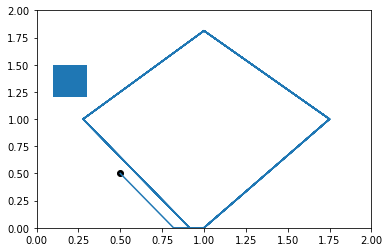

In [5]:
ini_ds = '00'
ini_cs = [0.5,0.5]
r2_ds = '01'
r2_interval = [[0.1,0.3],[0.2,0.5]]
new_interval = dc(r2_interval)
for i in range(len(list_entite)):
    new_interval[i][0] = r2_interval[i][0] + int(r2_ds[i])
    new_interval[i][1] = r2_interval[i][1] + int(r2_ds[i])

num = 40
data,t = simulation('00',[0.5,0.5],num)
plt.plot(data[0:num,0],data[0:num,1])
plt.scatter([0.5],[0.5],color='black')
rect=mpatches.Rectangle((new_interval[0][0],new_interval[1][0]),new_interval[0][1]-new_interval[0][0],new_interval[1][1]-new_interval[1][0])
plt.gca().add_patch(rect)
plt.xlim((0,2))
plt.ylim((0,2))
# plt.savefig('2d_reach.pdf')

In [6]:
reach(ini_ds,ini_cs,r2_ds,r2_interval)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:475: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:531: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:613: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


'Not reached'

## Reached example

(0, 2)

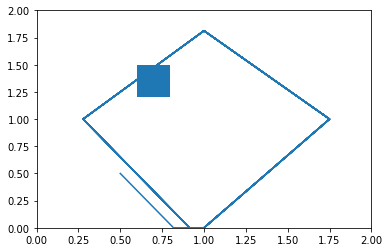

In [7]:
ini_ds = '00'
ini_cs = [0.5,0.5]
r2_ds = '01'
r2_interval = [[0.6,0.8],[0.2,0.5]]
new_interval = dc(r2_interval)
for i in range(len(list_entite)):
    new_interval[i][0] = r2_interval[i][0] + int(r2_ds[i])
    new_interval[i][1] = r2_interval[i][1] + int(r2_ds[i])

num = 40
data,t = simulation('00',[0.5,0.5],num)
plt.plot(data[0:num,0],data[0:num,1])
rect=mpatches.Rectangle((new_interval[0][0],new_interval[1][0]),new_interval[0][1]-new_interval[0][0],new_interval[1][1]-new_interval[1][0])
plt.gca().add_patch(rect)
plt.xlim((0,2))
plt.ylim((0,2))

In [8]:
reach(ini_ds,ini_cs,r2_ds,r2_interval)

'Reached'

# 3D model

## Repressilator with sustained oscillation

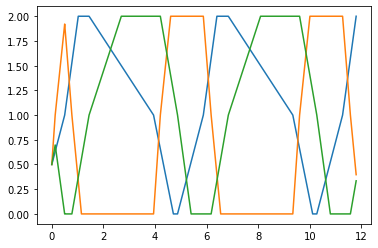

In [279]:
list_entite = ['a','b','c']
max_level = dict()
max_level['a'] = 1
max_level['b'] = 1
max_level['c'] = 1

list_colums = []
list_colums = list_colums + list_entite
for one_ele in list_entite:
    list_colums = list_colums + ['c_'+one_ele]
celerities = pd.DataFrame(columns=list_colums)

cac0a0=1
cac0a1=1.9
cac1a0=1.3
cac1a1=0.4
cba0b0=3.8
cba0b1=2.5
cba1b0=2.7
cba1b1=3.3
ccb0c0=1.5
ccb0c1=0.8
ccb1c0=1.9
ccb1c1=1.5

df1 = pd.DataFrame([[0,0,0,cac0a0,cba0b0,ccb0c0]],columns=list_colums)
df2 = pd.DataFrame([[0,0,1,-cac1a0,cba0b0,ccb0c1]],columns=list_colums)
df3 = pd.DataFrame([[0,1,0,cac0a0,cba0b1,-ccb1c0]],columns=list_colums)
df4 = pd.DataFrame([[0,1,1,-cac1a0,cba0b1,-ccb1c1]],columns=list_colums)
df5 = pd.DataFrame([[1,0,0,cac0a1,-cba1b0,ccb0c0]],columns=list_colums)
df6 = pd.DataFrame([[1,0,1,-cac1a1,-cba1b0,ccb0c1]],columns=list_colums)
df7 = pd.DataFrame([[1,1,0,cac0a1,-cba1b1,-ccb1c0]],columns=list_colums)
df8 = pd.DataFrame([[1,1,1,-cac1a1,-cba1b1,-ccb1c1]],columns=list_colums)

celerities = celerities.append(df1)
celerities = celerities.append(df2)
celerities = celerities.append(df3)
celerities = celerities.append(df4)
celerities = celerities.append(df5)
celerities = celerities.append(df6)
celerities = celerities.append(df7)
celerities = celerities.append(df8)
celerities['signature'] = celerities.apply(get_signature,axis=1)

num = 30
data,t = simulation('000',[0.5,0.5,0.5],num)
plt.plot(t[0:num],data[0:num,0],label='a')
plt.plot(t[0:num],data[0:num,1],label='b')
plt.plot(t[0:num],data[0:num,2],label='c')

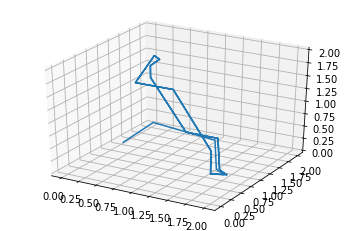

In [145]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = data[0:num,0]
y = data[0:num,1]
z = data[0:num,2]
ax.plot(x, y, z)
# ax.legend()
# plt.savefig('./img/3_negative.png', format='png', dpi=512)

In [280]:
ini_ds = '000'
ini_cs = [0.5,0.5,0.5]
r2_ds = '011'
r2_interval = [[0.6,0.8],[0.6,0.8],[0.6,0.8]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:475: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:531: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:613: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


'Not reached'

In [281]:
ini_ds = '000'
ini_cs = [0.5,0.5,0.5]
r2_ds = '011'
r2_interval = [[0.1,0.2],[0.8,1],[0.3,0.5]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

'Reached'

## Repressilator with damped oscillation

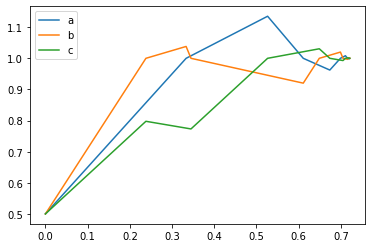

In [282]:
list_entite = ['a','b','c']
max_level = dict()
max_level['a'] = 1
max_level['b'] = 1
max_level['c'] = 1

list_colums = []
list_colums = list_colums + list_entite
for one_ele in list_entite:
    list_colums = list_colums + ['c_'+one_ele]
celerities = pd.DataFrame(columns=list_colums)

cac0a0=1.5
cac0a1=0.7
cac1a0=0.6
cac1a1=1.6
cba0b0=2.1
cba0b1=0.4
cba1b0=0.3
cba1b1=3.3
ccb0c0=1.25
ccb0c1=0.25
ccb1c0=0.23
ccb1c1=1.23

df1 = pd.DataFrame([[0,0,0,cac0a0,cba0b0,ccb0c0]],columns=list_colums)
df2 = pd.DataFrame([[0,0,1,-cac1a0,cba0b0,ccb0c1]],columns=list_colums)
df3 = pd.DataFrame([[0,1,0,cac0a0,cba0b1,-ccb1c0]],columns=list_colums)
df4 = pd.DataFrame([[0,1,1,-cac1a0,cba0b1,-ccb1c1]],columns=list_colums)
df5 = pd.DataFrame([[1,0,0,cac0a1,-cba1b0,ccb0c0]],columns=list_colums)
df6 = pd.DataFrame([[1,0,1,-cac1a1,-cba1b0,ccb0c1]],columns=list_colums)
df7 = pd.DataFrame([[1,1,0,cac0a1,-cba1b1,-ccb1c0]],columns=list_colums)
df8 = pd.DataFrame([[1,1,1,-cac1a1,-cba1b1,-ccb1c1]],columns=list_colums)

celerities = celerities.append(df1)
celerities = celerities.append(df2)
celerities = celerities.append(df3)
celerities = celerities.append(df4)
celerities = celerities.append(df5)
celerities = celerities.append(df6)
celerities = celerities.append(df7)
celerities = celerities.append(df8)
celerities['signature'] = celerities.apply(get_signature,axis=1)

num = 30
data,t = simulation('000',[0.5,0.5,0.5],num)
plt.plot(t[0:num],data[0:num,0],label='a')
plt.plot(t[0:num],data[0:num,1],label='b')
plt.plot(t[0:num],data[0:num,2],label='c')
plt.legend()

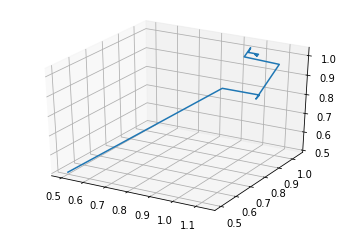

In [160]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = data[0:num,0]
y = data[0:num,1]
z = data[0:num,2]
ax.plot(x, y, z)
# ax.legend()
# plt.savefig('./img/3_negative.png', format='png', dpi=512)

In [283]:
ini_ds = '000'
ini_cs = [0.5,0.5,0.5]
r2_ds = '011'
r2_interval = [[0.6,0.8],[0.6,0.8],[0.6,0.8]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:475: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:531: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:613: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


'Not reached'

In [284]:
ini_ds = '000'
ini_cs = [0.5,0.5,0.5]
r2_ds = '011'
r2_interval = [[0.9,1],[0,0.1],[0,0.1]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

'Reached'

## Negative feedback loop with asymptotic limit cycle

In [286]:
list_entite = ['g1','g2','g3']
max_level = dict()
max_level['g1'] = 1
max_level['g2'] = 1
max_level['g3'] = 1

list_colums = []
list_colums = list_colums + list_entite
for one_ele in list_entite:
    list_colums = list_colums + ['c_'+one_ele]
celerities = pd.DataFrame(columns=list_colums)

df1 = pd.DataFrame([[0,0,0,3,-0.6,-0.7]],columns=list_colums)
df2 = pd.DataFrame([[0,0,1,3,0.7,-2.9]],columns=list_colums)
df3 = pd.DataFrame([[0,1,0,-2.8,-0.8,-0.7]],columns=list_colums)
df4 = pd.DataFrame([[0,1,1,-2.8,0.6,-2.9]],columns=list_colums)
df5 = pd.DataFrame([[1,0,0,2.7,-0.6,2.6]],columns=list_colums)
df6 = pd.DataFrame([[1,0,1,2.7,0.7,0.5]],columns=list_colums)
df7 = pd.DataFrame([[1,1,0,-2.9,-0.8,2.6]],columns=list_colums)
df8 = pd.DataFrame([[1,1,1,-2.9,0.6,0.5]],columns=list_colums)

celerities = celerities.append(df1)
celerities = celerities.append(df2)
celerities = celerities.append(df3)
celerities = celerities.append(df4)
celerities = celerities.append(df5)
celerities = celerities.append(df6)
celerities = celerities.append(df7)
celerities = celerities.append(df8)
celerities['signature'] = celerities.apply(get_signature,axis=1)

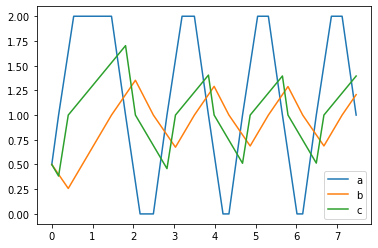

In [220]:
num = 30
data,t = simulation('000',[0.5,0.5,0.5],num)
plt.plot(t[0:num],data[0:num,0],label='a')
plt.plot(t[0:num],data[0:num,1],label='b')
plt.plot(t[0:num],data[0:num,2],label='c')
plt.legend()

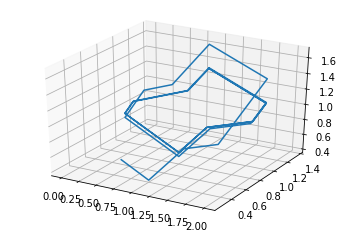

In [111]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = data[0:num,0]
y = data[0:num,1]
z = data[0:num,2]
ax.plot(x, y, z)

In [287]:
ini_ds = '000'
ini_cs = [0.5,0.5,0.5]
r2_ds = '011'
r2_interval = [[0.9,1],[0.2,0.3],[0.3,0.4]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:475: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:531: RuntimeWarning: divide by zero encountered in true_divide


'Reached'

In [288]:
ini_ds = '000'
ini_cs = [0.5,0.5,0.5]
r2_ds = '111'
r2_interval = [[0.9,1],[0.2,0.3],[0.3,0.4]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:475: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:531: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:613: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


'Not reached'

## Example with chaotic attractor

In [289]:
list_entite = ['x','y','z']
max_level = dict()
max_level['x'] = 1
max_level['y'] = 2
max_level['z'] = 1

a = 1.5
b = 0.7

list_colums = []
list_colums = list_colums + list_entite
for one_ele in list_entite:
    list_colums = list_colums + ['c_'+one_ele]
celerities = pd.DataFrame(columns=list_colums)

df1 = pd.DataFrame([[0,0,0,-1/6,(1+b)/3,1/12]],columns=list_colums)
df2 = pd.DataFrame([[0,0,1,-1/6,(1+b-a)/3,1/4]],columns=list_colums)
df3 = pd.DataFrame([[0,1,0,-1/6,(1-b)/1,1/12]],columns=list_colums)
df4 = pd.DataFrame([[0,1,1,-1/6,(1-b+a)/1,1/4]],columns=list_colums)
df5 = pd.DataFrame([[0,2,0,1/6,(1-b)/7,1/12]],columns=list_colums)
df6 = pd.DataFrame([[0,2,1,1/6,(1-b+a)/7,1/4]],columns=list_colums)
df7 = pd.DataFrame([[1,0,0,-1/8,(-1+b)/3,-1/12]],columns=list_colums)
df8 = pd.DataFrame([[1,0,1,-1/8,(-1+b-a)/3,-1/4]],columns=list_colums)
df9 = pd.DataFrame([[1,1,0,-1/8,(-1-b)/1,-1/12]],columns=list_colums)
df10 = pd.DataFrame([[1,1,1,-1/8,(-1-b+a)/1,-1/4]],columns=list_colums)
df11 = pd.DataFrame([[1,2,0,1/8,(-1-b)/7,-1/12]],columns=list_colums)
df12 = pd.DataFrame([[1,2,1,1/8,(-1-b+a)/7,-1/4]],columns=list_colums)

celerities = celerities.append(df1)
celerities = celerities.append(df2)
celerities = celerities.append(df3)
celerities = celerities.append(df4)
celerities = celerities.append(df5)
celerities = celerities.append(df6)
celerities = celerities.append(df7)
celerities = celerities.append(df8)
celerities = celerities.append(df9)
celerities = celerities.append(df10)
celerities = celerities.append(df11)
celerities = celerities.append(df12)
celerities['signature'] = celerities.apply(get_signature,axis=1)

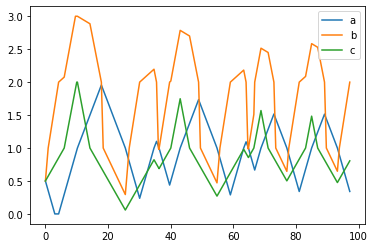

In [183]:
num = 50
data,t = simulation('000',[0.5,0.5,0.5],num)
plt.plot(t[0:num],data[0:num,0],label='a')
plt.plot(t[0:num],data[0:num,1],label='b')
plt.plot(t[0:num],data[0:num,2],label='c')
plt.legend()

In [290]:
ini_ds = '000'
ini_cs = [0.5,0.5,0.5]
r2_ds = '111'
r2_interval = [[0.9,1],[0.2,0.3],[0.3,0.4]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:475: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:531: RuntimeWarning: divide by zero encountered in true_divide


'Unknown'

# 5D model

In [3]:
list_entite = ['sk','ep','a','b','en']
max_level = dict()
max_level['sk'] = 2
max_level['ep'] = 1
max_level['a'] = 1
max_level['b'] = 1
max_level['en'] = 1
celerities = pd.read_csv('celerity5d.csv')
celerities['signature'] = celerities.apply(get_signature,axis=1)


In [230]:
celerities.head()

,sk,ep,a,b,en,c_sk,c_ep,c_a,c_b,c_en,signature
0,0,0,0,0,0,0.171429,-0.421197,0.481899,0.126388,0.486555,00000
1,0,0,0,0,1,0.171429,-0.421197,-0.565591,-6.630917,0.403097,00001
2,0,0,0,1,0,0.171429,0.250000,-0.065449,0.694524,0.486555,00010
3,0,0,0,1,1,0.171429,0.250000,-5.393131,-6.000000,0.403097,00011
4,0,0,1,0,0,-1.528967,-0.421197,0.918569,0.124537,-0.639516,00100


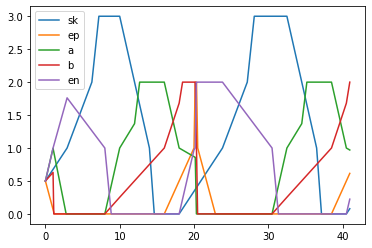

In [4]:
num = 40
data,t = simulation('00000',[0.5,0.5,0.5,0.5,0.5],num)
plt.plot(t[0:num],data[0:num,0],label=list_entite[0])
plt.plot(t[0:num],data[0:num,1],label=list_entite[1])
plt.plot(t[0:num],data[0:num,2],label=list_entite[2])
plt.plot(t[0:num],data[0:num,3],label=list_entite[3])
plt.plot(t[0:num],data[0:num,4],label=list_entite[4])
plt.legend()

In [293]:
ini_ds = '00000'
ini_cs = [0.5,0.5,0.5,0.5,0.5]
r2_ds = '00001'
r2_interval = [[0.82,0.84],[0,0.01],[0,0.01],[0,0.01],[0.99,1]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

'Reached'

In [294]:
ini_ds = '00000'
ini_cs = [0.5,0.5,0.5,0.5,0.5]
r2_ds = '21010'
r2_interval = [[0,1],[0,1],[0,1],[0,1],[0,1]]
reach(ini_ds,ini_cs,r2_ds,r2_interval)

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:475: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:531: RuntimeWarning: divide by zero encountered in true_divide


'Not reached'

Estimating the basins of attraction of the stable limit cycle and the stable fixed point

In [ ]:
r2_ds = '00001'
r2_interval = [[0.82,0.84],[0,0.01],[0,0.01],[0,0.01],[0.99,1]]
r2p_ds = '21010'
r2p_interval = [[0,1],[0,1],[0,1],[0,1],[0,1]]
pro_basin = dict()
# with open('pro_basin.pkl', 'rb') as f:
#     pro_basin = pickle.load(f)
list_ds = list(celerities['signature'])
for one_ds in list_ds:
    nb1 = 0
    nb2 = 0
    sample = 20
    for i in range(20):
        ini_ds = one_ds
        ini_cs = [np.random.uniform(),np.random.uniform(),np.random.uniform(),np.random.uniform(),np.random.uniform()]

        res1 = reach(ini_ds,ini_cs,r2_ds,r2_interval)
        res2 = reach(ini_ds,ini_cs,r2p_ds,r2p_interval)
        if res1 == 'Reached' and res2 == 'Not reached':
            nb1 = nb1+1
        elif res1 == 'Not reached' and res2 == 'Reached':
            nb2 = nb2+1
        else:
            print('unpredicted result')
    pro_basin[one_ds] = [nb1/sample,nb2/sample]
# execution time: 30 minutes

Visualizing the results

In [26]:
nb_state = celerities.shape[0]
graph = dict()
for i in range(nb_state):
    current_parameter = celerities.iloc[i]
    current_state = ''
    for ele in list_entite:
        current_state = current_state + str(current_parameter[ele])
    # current state: '01' '00'
    graph[current_state] = []
    for j in range(len(list_entite)):
        ele = list_entite[j]
        current_level = current_parameter[ele]
        current_speed = current_parameter['c_'+ele]
        if current_level < max_level[ele] and current_speed > 0:
            next_state = current_state[0:j] + str(current_level+1) + current_state[j+1:]
            next_speed = get_celerity(next_state,j)
            if next_speed > 0:
                graph[current_state] = graph[current_state] + [next_state]
        elif current_level > 0 and current_speed < 0:
            next_state = current_state[0:j] + str(current_level-1) + current_state[j+1:]
            next_speed = get_celerity(next_state,j)
            if next_speed <0:
                graph[current_state] = graph[current_state] + [next_state]
    if graph[current_state] == []:
        graph[current_state] = [current_state]
        
dict_limit_cycle = dict()
dict_limit_cycle['00001'] = '10001'
dict_limit_cycle['10001'] = '20001'
dict_limit_cycle['20001'] = '20000'
dict_limit_cycle['20000'] = '20100'
dict_limit_cycle['20100'] = '10100'
dict_limit_cycle['10100'] = '00100'
dict_limit_cycle['00100'] = '00110'
dict_limit_cycle['00110'] = '00010'
dict_limit_cycle['00010'] = '01010'
dict_limit_cycle['01010'] = '01011'
dict_limit_cycle['01011'] = '01001'
dict_limit_cycle['01001'] = '00001'
        
dot = Digraph(format='pdf')
for ele in list(graph.keys()):
    if ele == '21010':
        dot.node(ele,ele+'\n'+"{:4.2f}".format(pro_basin[ele][0])+' '+"{:4.2f}".format(pro_basin[ele][1]),color='red',fontsize='32')
    else:
        dot.node(ele,ele+'\n'+"{:4.2f}".format(pro_basin[ele][0])+' '+"{:4.2f}".format(pro_basin[ele][1]),fontsize='32')
    list_edge = []
    for one in graph[ele]:
        if ele in list(dict_limit_cycle.keys()) and dict_limit_cycle[ele] == one:
            dot.edge(ele,one,color='red',arrowsize='2')
        else:
            dot.edge(ele,one,arrowsize='2')
dot.render(view=True)

'Digraph.gv.pdf'